In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['aptos2019-blindness-detection', 'resnet50']


In [2]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [4]:
print(train_df.shape, test_df.shape)

(3662, 2) (1928, 1)


In [5]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 768
WIDTH = 768
CANAL = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [6]:
def createClasses(val):
    listofzeros = [0] * 4
    for i in range(val):
        listofzeros[i] = 1
    return listofzeros

In [7]:
train_df['diagnosis_list'] = train_df['diagnosis'].apply(createClasses)

In [8]:
train_df[['1','2','3','4']] = pd.DataFrame(train_df['diagnosis_list'].values.tolist(), index= train_df.index)

In [9]:
# Preprocecss data
train_df["id_code"] = train_df["id_code"].apply(lambda x: x + ".png")
test_df["id_code"] = test_df["id_code"].apply(lambda x: x + ".png")
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df.head()

,id_code,diagnosis,diagnosis_list,1,2,3,4
0,000c1434d8d7.png,2,"[1, 1, 0, 0]",1,1,0,0
1,001639a390f0.png,4,"[1, 1, 1, 1]",1,1,1,1
2,0024cdab0c1e.png,1,"[1, 0, 0, 0]",1,0,0,0
3,002c21358ce6.png,0,"[0, 0, 0, 0]",0,0,0,0
4,005b95c28852.png,0,"[0, 0, 0, 0]",0,0,0,0


In [10]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col=['1','2','3','4'],
    batch_size=BATCH_SIZE,
#     class_mode="categorical",
    class_mode='raw',
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col=['1','2','3','4'],
    batch_size=BATCH_SIZE,
#     class_mode="categorical",
    class_mode='raw',
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test_df,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames.
Found 732 validated image filenames.
Found 1928 validated image filenames.


In [11]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [12]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 774, 774, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 384, 384, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 384, 384, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=1).history

Epoch 1/2
366/366 [==============================] - 450s 1s/step - loss: 0.3895 - acc: 0.8550 - val_loss: 2.5975 - val_acc: 0.7054
Epoch 2/2
366/366 [==============================] - 425s 1s/step - loss: 0.2907 - acc: 0.8857 - val_loss: 2.9627 - val_acc: 0.7017


In [14]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 774, 774, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 384, 384, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 384, 384, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [15]:
history_finetunning = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=1).history

Epoch 1/20
366/366 [==============================] - 478s 1s/step - loss: 0.2099 - acc: 0.9178 - val_loss: 0.1946 - val_acc: 0.9209
Epoch 2/20
366/366 [==============================] - 460s 1s/step - loss: 0.1728 - acc: 0.9314 - val_loss: 0.1592 - val_acc: 0.9416
Epoch 3/20
366/366 [==============================] - 459s 1s/step - loss: 0.1475 - acc: 0.9408 - val_loss: 0.2034 - val_acc: 0.9292
Epoch 4/20
366/366 [==============================] - 457s 1s/step - loss: 0.1324 - acc: 0.9442 - val_loss: 0.4174 - val_acc: 0.8577
Epoch 5/20
366/366 [==============================] - 459s 1s/step - loss: 0.1314 - acc: 0.9465 - val_loss: 0.1687 - val_acc: 0.9368

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/20
366/366 [==============================] - 458s 1s/step - loss: 0.1010 - acc: 0.9588 - val_loss: 0.1633 - val_acc: 0.9358
Epoch 7/20
366/366 [==============================] - 457s 1s/step - loss: 0.0880 - acc: 0.9638 - val_loss: 0.1463 - val_

In [16]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train_df,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)


Found 3662 validated image filenames.


In [17]:
train_preds = [sum(pred>0.5) for pred in train_preds]

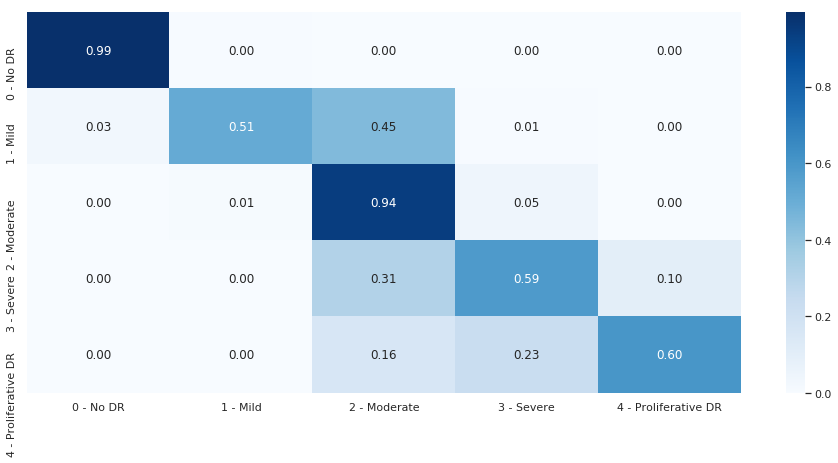

In [18]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train_df['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [19]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_df['diagnosis'].astype('int'), weights='quadratic')

SyntaxError: unexpected EOF while parsing (<ipython-input-19-5ae8be99e07f>, line 1)

In [20]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [sum(pred>0.5) for pred in preds]

In [21]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,0
